In [2]:
import pandas as pd
df=pd.read_csv("/Users/anishjain/Downloads/AEP_hourly.csv")

In [3]:
print(df.head())
print(df.tail())

              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0
                   Datetime   AEP_MW
121268  2018-01-01 20:00:00  21089.0
121269  2018-01-01 21:00:00  20999.0
121270  2018-01-01 22:00:00  20820.0
121271  2018-01-01 23:00:00  20415.0
121272  2018-01-02 00:00:00  19993.0


In [4]:
df.size

242546

In [5]:
df.shape

(121273, 2)

In [6]:
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [7]:
from datetime import datetime 
df['Datetime']=pd.to_datetime(df['Datetime'],infer_datetime_format=True)
df1=df.set_index(['Datetime'])
print(df1.head())

                      AEP_MW
Datetime                    
2004-12-31 01:00:00  13478.0
2004-12-31 02:00:00  12865.0
2004-12-31 03:00:00  12577.0
2004-12-31 04:00:00  12517.0
2004-12-31 05:00:00  12670.0


/var/folders/pj/bb0blhm15x7dw5v23gt3sxvc0000gn/T/ipykernel_4514/3976146218.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Datetime']=pd.to_datetime(df['Datetime'],infer_datetime_format=True)


In [10]:
import numpy as np 
import matplotlib.pyplot as plt
#import seaborn as sns

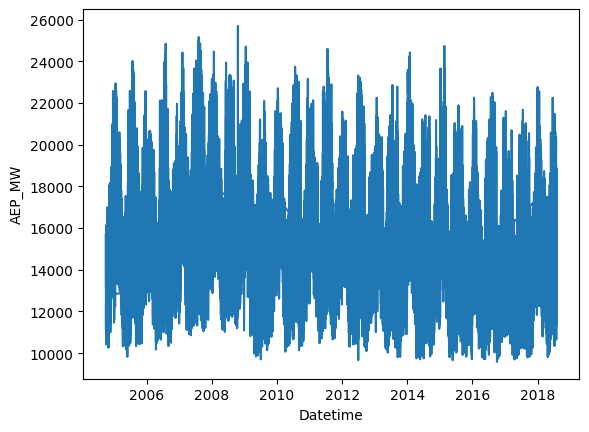

In [11]:
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.plot(df1)
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

print("Stationarity Test on Original Data:")
adf_test(df1['AEP_MW'])

Stationarity Test on Original Data:
ADF Statistic: -16.446812104688746
p-value: 2.3990113239921483e-29
Critical Values: {'1%': -3.430403955318047, '5%': -2.8615638474512295, '10%': -2.566782693155802}
Data is stationary


In [19]:
#Step 3: Fit ARIMA model (using identified p, d, q values)
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(df1['AEP_MW'], order=(1,0,2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has bee

                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:               121273
Model:                 ARIMA(1, 0, 2)   Log Likelihood             -924589.010
Date:                Tue, 01 Apr 2025   AIC                        1849188.020
Time:                        16:36:32   BIC                        1849236.549
Sample:                             0   HQIC                       1849202.621
                             - 121273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.55e+04     42.159    367.646      0.000    1.54e+04    1.56e+04
ar.L1          0.9333      0.001    764.610      0.000       0.931       0.936
ma.L1          0.6074      0.001    443.445      0.0

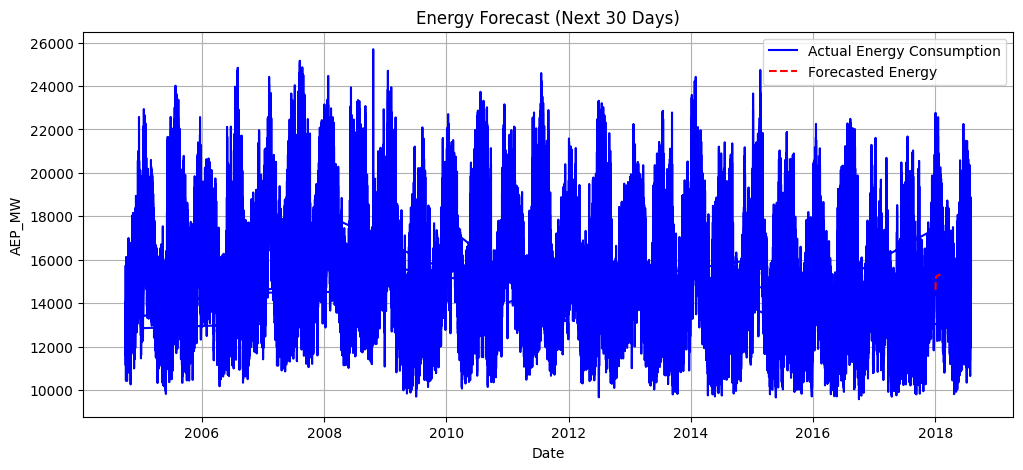

In [27]:
# Forecast the next 30 days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)

# Generate correct future dates based on last available date
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot actual vs forecasted values
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["AEP_MW"], label="Actual Energy Consumption", color="blue")
plt.plot(future_dates, forecast, label="Forecasted Energy", linestyle="dashed", color="red")
plt.title("Energy Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("AEP_MW")
plt.legend()
plt.grid()
plt.show()


In [28]:
# Display forecasted values
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Price': forecast}).set_index('Date')
print(forecast_df.head())

            Forecasted_Price
Date                        
2018-01-03      14613.712694
2018-01-04      14986.886551
2018-01-05      15130.153553
2018-01-06      15187.262969
2018-01-07      15212.043018


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get actual and predicted values
actual = df["AEP_MW"].iloc[-30:]  # Last 30 days of actual data
predicted = model_fit.forecast(steps=30)

# Calculate error metrics
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 4725.80
Mean Squared Error (MSE): 23713213.25
Root Mean Squared Error (RMSE): 4869.62


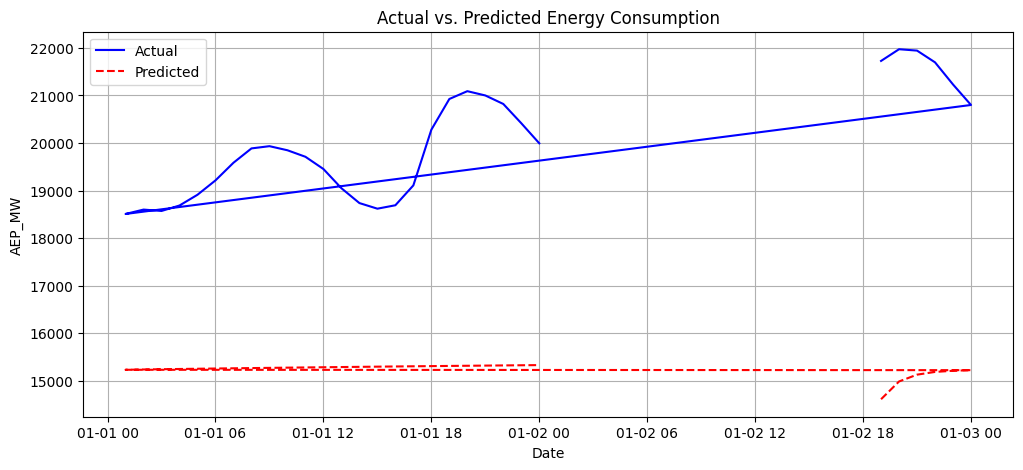

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(df.index[-30:], actual, label="Actual", color="blue")
plt.plot(df.index[-30:], predicted, label="Predicted", linestyle="dashed", color="red")
plt.title("Actual vs. Predicted Energy Consumption")
plt.xlabel("Date")
plt.ylabel("AEP_MW")
plt.legend()
plt.grid()
plt.show()


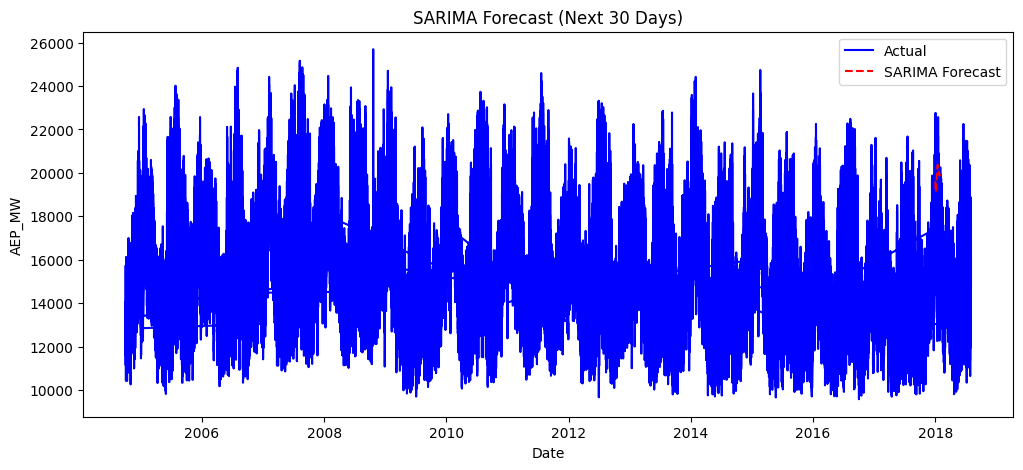

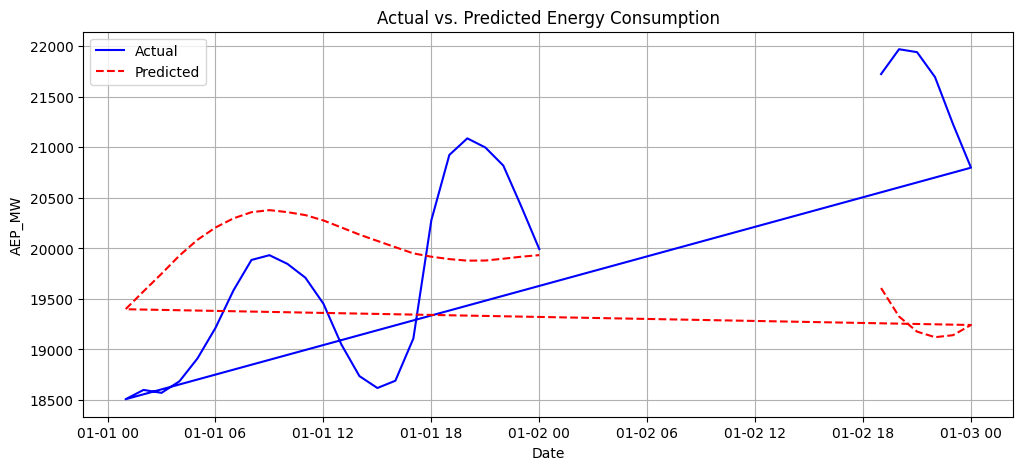

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a Seasonal ARIMA model
model_sarima = SARIMAX(df["AEP_MW"], order=(2, 1, 2), seasonal_order=(1, 1, 1, 7))  # Weekly seasonality
model_fit_sarima = model_sarima.fit()

# Forecast future values
forecast_sarima = model_fit_sarima.forecast(steps=30)

# Plot SARIMA Forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["AEP_MW"], label="Actual", color="blue")
plt.plot(pd.date_range(df.index[-1], periods=30, freq="D"), forecast_sarima, label="SARIMA Forecast", linestyle="dashed", color="red")
plt.title("SARIMA Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("AEP_MW")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df.index[-30:], actual, label="Actual", color="blue")
plt.plot(df.index[-30:], forecast_sarima, label="Predicted", linestyle="dashed", color="red")
plt.title("Actual vs. Predicted Energy Consumption")
plt.xlabel("Date")
plt.ylabel("AEP_MW")
plt.legend()
plt.grid()
plt.show()



In [35]:
import numpy as np

# Get actual and predicted values for the last 30 days
actual_sarima = df["AEP_MW"].iloc[-30:]  # Last 30 days actual data
predicted_sarima = model_fit_sarima.forecast(steps=30)  # SARIMA forecast

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.where(y_true == 0, 1e-10, y_true)  # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#def mean_absolute_percentage_error(y_true, y_pred):
   # return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape_sarima = mean_absolute_percentage_error(actual_sarima, predicted_sarima)
print(f"Mean Absolute Percentage Error (MAPE) for SARIMA: {mape_sarima:.2f}%")


Mean Absolute Percentage Error (MAPE) for SARIMA: 5.80%
